In [5]:
%pip install -qU aiobotocore 
%pip install -q jsonlines
%pip install -q requests_aws4auth
%pip install -q elasticsearch==7.13.4

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [7]:
!mkdir -p data
!aws s3 cp --no-sign-request s3://amazon-berkeley-objects/README.md data/README.md 

download: s3://amazon-berkeley-objects/README.md to data/README.md


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL.Image import Image as PilImage
import textwrap, os
import sagemaker
from sagemaker.serverless.serverless_inference_config import ServerlessInferenceConfig
from sagemaker.serializers import JSONSerializer, IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

%matplotlib inline

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
s3_bucket_name = sagemaker.session.Session().default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
print(s3_bucket_name)

sagemaker-us-east-2-816546967292


In [6]:
meta = pd.read_json("s3://amazon-berkeley-objects/listings/metadata/listings_0.json.gz", lines=True)
def func_(x):
    us_texts = [item["value"] for item in x if item["language_tag"] == "en_US"]
    return us_texts[0] if us_texts else None

meta = meta.assign(item_name_in_en_us=meta.item_name.apply(func_))
meta = meta[~meta.item_name_in_en_us.isna()][["item_id", "item_name_in_en_us", "main_image_id"]]
print(f"#products with US English title: {len(meta)}")
meta.head()

#products with US English title: 1655


,item_id,item_name_in_en_us,main_image_id
7,B0896LJNLH,AmazonBasics Serene 16-Piece Old Fashioned and...,61izEZdhlaL
18,B07HCR1LSQ,[Find] Amazon Collection Platinum Plated Sterl...,61kDp2x8tPL
22,B075DQBBJZ,Arizona Desert Sand Horizon Photo with Wood Ha...,91IjyKZ76qL
38,B07S74D9T7,AmazonBasics Adjustable Speaker Stand - 3.8 to...,71x4c-BafpL
39,B01N27SMXC,Amazon Brand - The Fix Women's Foley Tassel Sl...,71-eMu0gN+L


In [7]:
image_meta = pd.read_csv("s3://amazon-berkeley-objects/images/metadata/images.csv.gz")
dataset = meta.merge(image_meta, left_on="main_image_id", right_on="image_id")
dataset.head()


,item_id,item_name_in_en_us,main_image_id,image_id,height,width,path
0,B0896LJNLH,AmazonBasics Serene 16-Piece Old Fashioned and...,61izEZdhlaL,61izEZdhlaL,1197,894,07/075e5d67.jpg
1,B07HCR1LSQ,[Find] Amazon Collection Platinum Plated Sterl...,61kDp2x8tPL,61kDp2x8tPL,1000,1000,c9/c923418f.jpg
2,B075DQBBJZ,Arizona Desert Sand Horizon Photo with Wood Ha...,91IjyKZ76qL,91IjyKZ76qL,2560,2560,c6/c6889ed4.jpg
3,B07S74D9T7,AmazonBasics Adjustable Speaker Stand - 3.8 to...,71x4c-BafpL,71x4c-BafpL,2560,2560,2b/2b90e918.jpg
4,B01N27SMXC,Amazon Brand - The Fix Women's Foley Tassel Sl...,71-eMu0gN+L,71-eMu0gN+L,704,1770,2c/2c0416de.jpg


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set


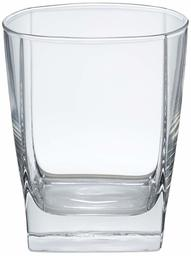

In [8]:
from sagemaker.s3 import S3Downloader as s3down
from pathlib import Path
from PIL import Image

s3_data_root = "s3://amazon-berkeley-objects/images/small/"

def get_image_from_item_id(item_id = "B0896LJNLH", return_image=True):
    
    item_idx = dataset.query(f"item_id == '{item_id}'").index[0]
    s3_path = dataset.iloc[item_idx].path
    local_data_root = f'./data/images'
    local_file_name = Path(s3_path).name
    #print({s3_data_root}{s3_path})
    s3down.download(f'{s3_data_root}{s3_path}', local_data_root)

    local_image_path = f"{local_data_root}/{local_file_name}"
    if return_image:
        img = Image.open(local_image_path)
        return img, dataset.iloc[item_idx].item_name_in_en_us
    else:
        return local_image_path, dataset.iloc[item_idx].item_name_in_en_us
image, item_name = get_image_from_item_id()
print(item_name)
image

In [9]:
%%writefile build_model_tar.sh
#!/bin/bash
BUCKET_NAME="$1"
MODEL_NAME=RN50.pt
MODEL_NAME_URL=https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt

BUILD_ROOT=/tmp/model_path
S3_PATH=s3://${BUCKET_NAME}/models/clip/model.tar.gz


rm -rf $BUILD_ROOT
mkdir $BUILD_ROOT
cd $BUILD_ROOT && curl -o $BUILD_ROOT/$MODEL_NAME $MODEL_NAME_URL
cd $BUILD_ROOT && tar -czvf model.tar.gz .
aws s3 cp $BUILD_ROOT/model.tar.gz  $S3_PATH

Overwriting build_model_tar.sh


In [10]:
!bash build_model_tar.sh {s3_bucket_name}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  243M  100  243M    0     0  45.9M      0  0:00:05  0:00:05 --:--:-- 46.8M
./
./RN50.pt
tar: .: file changed as we read it
upload: ./model.tar.gz to s3://sagemaker-us-east-2-816546967292/models/clip/model.tar.gz


In [11]:
!aws s3 ls s3://{s3_bucket_name}/models/clip/model.tar.gz

2023-11-16 15:50:01  202159837 model.tar.gz


In [16]:
!mkdir -p code

In [17]:
%%writefile code/clip_inference.py

import io
import torch
import clip
from PIL import Image
import json
import logging
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

MODEL_NAME = os.environ.get("MODEL_NAME", "RN50.pt")
# ENCODE_TYPE could be IMAGE or TEXT
ENCODE_TYPE = os.environ.get("ENCODE_TYPE", "TEXT")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# defining model and loading weights to it.
def model_fn(model_dir):
    model, preprocess = clip.load(os.path.join(model_dir, MODEL_NAME), device=device)
    return {"model_obj": model, "preprocess_fn": preprocess}


def load_from_bytearray(request_body):
    
    return image

# data loading
def input_fn(request_body, request_content_type):
    assert request_content_type in (
        "application/json",
        "application/x-image",
    ), f"{request_content_type} is an unknown type."
    if request_content_type == "application/json":
        data = json.loads(request_body)["inputs"]
    elif request_content_type == "application/x-image":
        image_as_bytes = io.BytesIO(request_body)
        data = Image.open(image_as_bytes)
    return data


# inference
def predict_fn(input_object, model):
    model_obj = model["model_obj"]
    # for image preprocessing
    preprocess_fn = model["preprocess_fn"]
    assert ENCODE_TYPE in ("TEXT", "IMAGE"), f"{ENCODE_TYPE} is an unknown encode type."

    # preprocessing
    if ENCODE_TYPE == "TEXT":
        input_ = clip.tokenize(input_object).to(device)
    elif ENCODE_TYPE == "IMAGE":
        input_ = preprocess_fn(input_object).unsqueeze(0).to(device)

    # inference
    with torch.no_grad():
        if ENCODE_TYPE == "TEXT":
            prediction = model_obj.encode_text(input_)
        elif ENCODE_TYPE == "IMAGE":
            prediction = model_obj.encode_image(input_)
    return prediction


# Serialize the prediction result into the desired response content type
def output_fn(predictions, content_type):
    assert content_type == "application/json"
    res = predictions.cpu().numpy().tolist()
    return json.dumps(res)

Overwriting code/clip_inference.py


In [18]:
%%writefile code/requirements.txt
ftfy
regex
tqdm
git+https://github.com/openai/CLIP.git

Overwriting code/requirements.txt


In [19]:
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role, Session


role = get_execution_role()
shared_params = dict(
    entry_point="clip_inference.py",
    source_dir="code",
    role=role,
    model_data=f"s3://{s3_bucket_name}/models/clip/model.tar.gz",
    framework_version="1.9.0",
    py_version="py38",
)

clip_image_model = PyTorchModel(
    env={'MODEL_NAME': 'RN50.pt', "ENCODE_TYPE": "IMAGE"},
    name="clip-image-model",
    **shared_params
)

clip_text_model = PyTorchModel(
    env={'MODEL_NAME': 'RN50.pt', "ENCODE_TYPE": "TEXT"},
    name="clip-text-model",
    **shared_params
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [ ]:
from multiprocessing.pool import ThreadPool
import boto3
import tqdm.notebook as tq
from urllib.parse import urlparse
import logging
from botocore.exceptions import ClientError

# Configure logging
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

s3_sample_image_root = f"s3://{s3_bucket_name}/sample-images"

client = boto3.client('s3')

def upload_(args):
    try:
        client.copy_object(CopySource=args["source"], Bucket=args["target_bucket"], Key=args["target_key"])
    except ClientError as e:
        logger.error("Error copying object: %s", e.response['Error']['Message'])
        return False
    return True

arguments = []
for idx, record in dataset.head(50).iterrows():
    argument = {}
    argument["source"] = (s3_data_root + record.path)[5:]
    argument["target_bucket"] = urlparse(s3_sample_image_root).netloc
    argument["target_key"] = urlparse(s3_sample_image_root).path[1:] + '/' + record.path
    arguments.append(argument)

with ThreadPool(4) as p:
    results = list(tq.tqdm(p.imap(upload_, arguments), total=len(dataset.head(50))))
# Check for failed uploads
failed_uploads = [res for res in results if not res]
if failed_uploads:
    logger.error("Some uploads failed.")    

In [22]:
print(len(dataset))

1649


In [23]:
import logging

# Set the logging level to ERROR to only print error logs
logging.basicConfig(level=logging.ERROR)

# If you have already configured logging before in the same notebook,
# you might need to update the level like this:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [ ]:
batch_input = s3_sample_image_root + "/"
output_path = f"s3://{s3_bucket_name}/inference/clip-search/output/"

clip_image_transformer = clip_image_model.transformer(
    instance_count=1,
    instance_type="ml.c5.xlarge",
    strategy="SingleRecord",
    assemble_with="Line",
    output_path=output_path,
)

clip_image_transformer.transform(
    batch_input, 
    data_type="S3Prefix",
    content_type="application/x-image", 
    wait=True,
    logs=False
)

In [ ]:
from sagemaker.s3 import S3Downloader
import json

embedding_root_path = "./data/embedding"
s3down.download(output_path, embedding_root_path)

embeddings = []
for idx, record in dataset.head(50).iterrows():
    embedding_file = f"{embedding_root_path}/{record.path}.out"
    embeddings.append(json.load(open(embedding_file))[0])

In [ ]:
print(len(embeddings))

In [38]:
print(dataset.head(1))

      item_id                                 item_name_in_en_us  \
0  B0896LJNLH  AmazonBasics Serene 16-Piece Old Fashioned and...   

  main_image_id     image_id  height  width             path  
0   61izEZdhlaL  61izEZdhlaL    1197    894  07/075e5d67.jpg  


In [41]:
!pip install pymongo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.1/677.1 kB 4.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 3.0 MB/s eta 0:00:00:00:01


In [ ]:
import pymongo
from pymongo import MongoClient

# Replace the following with your MongoDB connection details
mongo_uri = "url"
db_name = "vectorsearch"
image_metadata_collection_name = "image_metadata"
embeddings_collection_name = "embeddings"

# Connect to your MongoDB
client = MongoClient(mongo_uri)
db = client[db_name]
image_metadata_collection = db[image_metadata_collection_name]
embeddings_collection = db[embeddings_collection_name]

# Iterate over the dataset and embeddings
for idx, row in dataset.iterrows():
    # Construct the image metadata document
    image_metadata_document = {
        "item_id": row["item_id"],
        "item_name_in_en_us": row["item_name_in_en_us"],
        "main_image_id": row["main_image_id"],
        "image_id": row["image_id"],
        "height": row["height"],
        "width": row["width"],
        "path": row["path"]
    }
    
    # Construct the embeddings document
    embeddings_document = {
        "item_id": row["item_id"],
        # Assuming embeddings is a list or array-like structure and has the same order as the dataset
        "embedding": embeddings[idx]  # Convert numpy array to list if necessary
    }
    
    # Insert the documents into MongoDB
    try:
        image_metadata_collection.insert_one(image_metadata_document)
        embeddings_collection.insert_one(embeddings_document)
        print(f"Inserted documents for item_id {row['item_id']}")
    except pymongo.errors.PyMongoError as e:
        print(f"Error inserting documents for item_id {row['item_id']}: {e}")

# Close the connection to MongoDB
client.close()


In [ ]:
text_predictor = clip_text_model.deploy(
    instance_type='ml.c5.xlarge',
    initial_instance_count=1,
    serverless_inference_config=ServerlessInferenceConfig(memory_size_in_mb=6144),
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
    wait=True
)

image_predictor = clip_image_model.deploy(
    instance_type='ml.c5.xlarge',
    initial_instance_count=1,
    serverless_inference_config=ServerlessInferenceConfig(memory_size_in_mb=6144),
    serializer=IdentitySerializer(content_type="application/x-image"),
    deserializer=JSONDeserializer(),
    wait=True
)

def encode_image(file_name="./data/images/0e9420c6.jpg"):    
    with open(file_name, "rb") as f:
        payload = f.read()
        payload = bytearray(payload)
    res = image_predictor.predict(payload)
    return res[0]

def encode_name(item_name):
    res = text_predictor.predict({"inputs": [f"this is a {item_name}"]})
    return res[0]

In [67]:
item_image_path, item_name = get_image_from_item_id(item_id = "B0896LJNLH", return_image=False)
print(item_image_path)
feature_vector = encode_image(file_name=item_image_path)

#print(feature_vector)
#Image.open(item_image_path)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
./data/images/075e5d67.jpg


In [69]:

results = embeddings_collection.aggregate([
  {"$vectorSearch": {
    "queryVector": feature_vector,
    "path": "embedding",
    "numCandidates": 100,
    "limit": 4,
    "index": "imagesearch",
      }}
]);

# Iterate over the results from the vector search
for document in results:
    item_id = document["item_id"]
    print(f'Search result item_id: {item_id}')
    
    # Retrieve the corresponding document from the image_metadata collection
    metadata_document = image_metadata_collection.find_one({"item_id": item_id})
    
    if metadata_document:
        # Print the details from the image_metadata collection
        print(f'Image Metadata for item_id {item_id}: {metadata_document}')
    else:
        print(f'No metadata found for item_id {item_id}')

Search result item_id: B0896LJNLH
Image Metadata for item_id B0896LJNLH: {'_id': ObjectId('654a8cba19b59a6ae225a806'), 'item_id': 'B0896LJNLH', 'item_name_in_en_us': 'AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set', 'main_image_id': '61izEZdhlaL', 'image_id': '61izEZdhlaL', 'height': 1197, 'width': 894, 'path': '07/075e5d67.jpg'}
Search result item_id: B0896KVCJY
Image Metadata for item_id B0896KVCJY: {'_id': ObjectId('654a8cbf19b59a6ae225a810'), 'item_id': 'B0896KVCJY', 'item_name_in_en_us': 'AmazonBasics Eastlake Coolers Glass Drinkware Set, 15-Ounce, Set of 6', 'main_image_id': '610jXVKNJpL', 'image_id': '610jXVKNJpL', 'height': 1630, 'width': 863, 'path': 'ea/ea0c6da6.jpg'}
Search result item_id: B07DBFT2YG
Image Metadata for item_id B07DBFT2YG: {'_id': ObjectId('654a8cd319b59a6ae225a85e'), 'item_id': 'B07DBFT2YG', 'item_name_in_en_us': 'Amazon Brand – Ravenna Home Angela Modern Turned Leg Wood Shelf Storage Coffee Table, 44"W, Grey', 'main_image_id': '6